In [138]:
# Basic Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sci-kit learn imports
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [139]:
# 1 - Load CSV file
abalone = pd.read_csv("abalone.csv")

1 b) The abalone dataset does not require any conversions as none of its features are strings.
The target that we are trying to predict is a string, but not a feature. Therefore, we do not need to convert it. 

In [140]:
# Convert dataset to numpy array and split into features/target
X = abalone.to_numpy()[:, 1:8]
y = abalone.to_numpy()[:, 0]

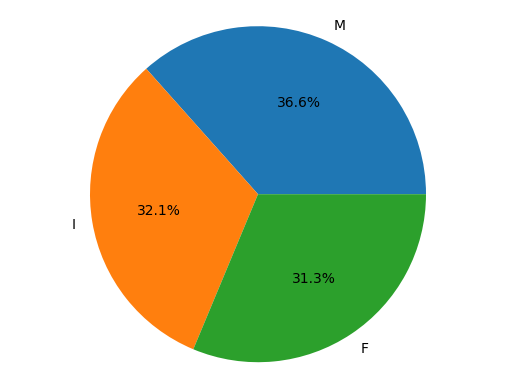

In [141]:
# 2 - Percentages of each output class
labels = 'M', 'I', 'F'
sizes = abalone['Type'].value_counts(normalize=True) * 100

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.savefig("abalone-classes")

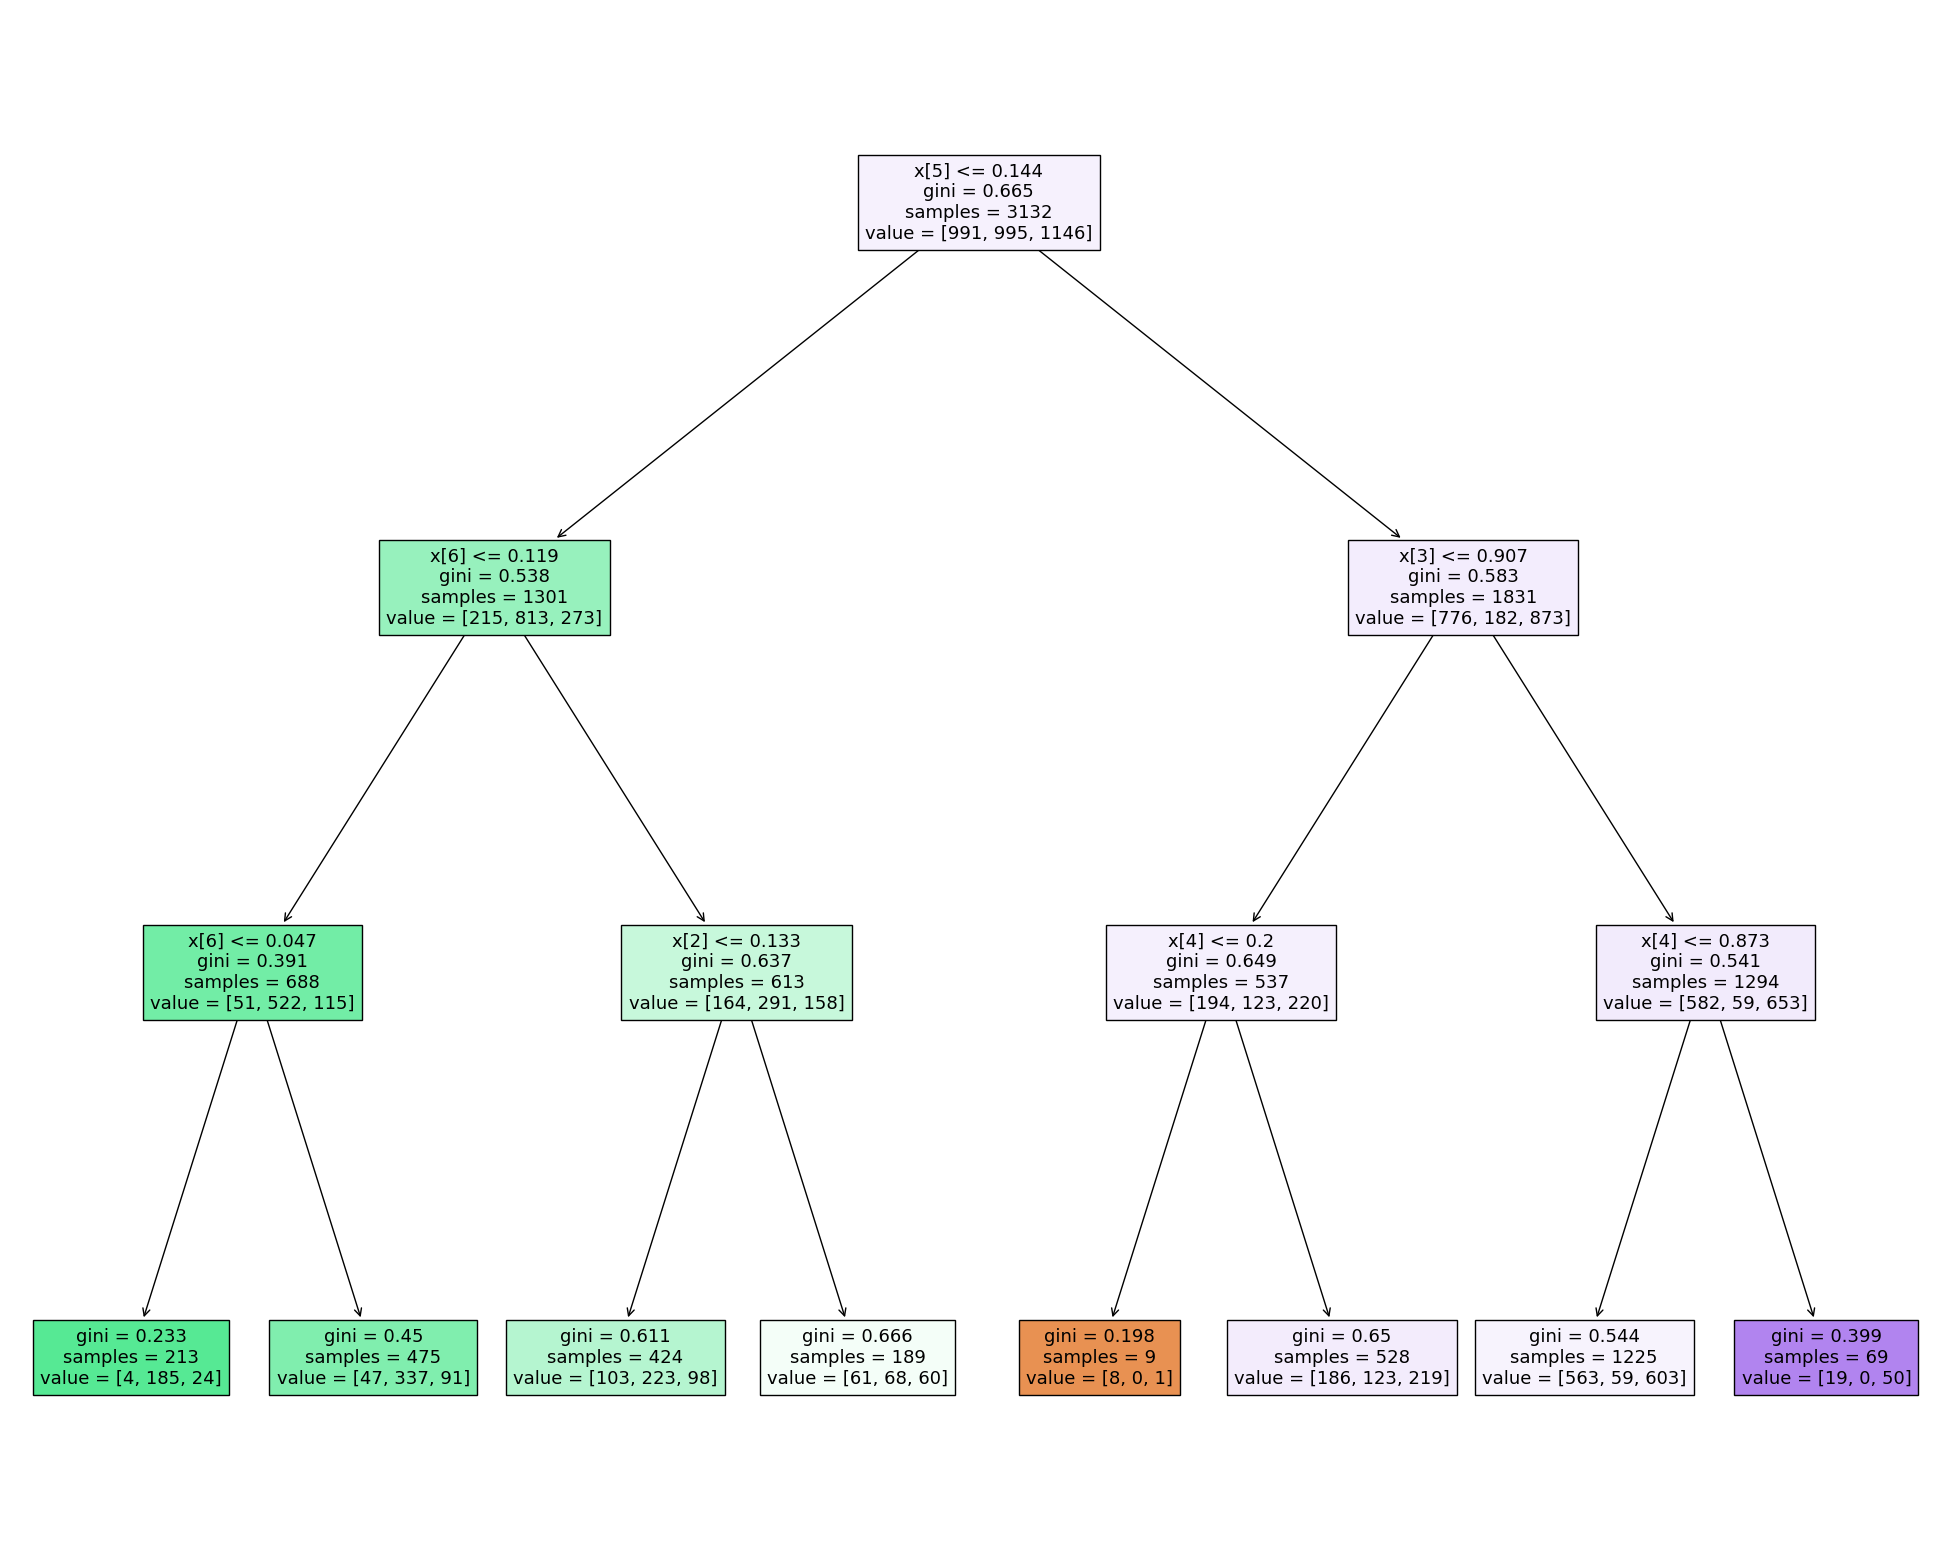

In [142]:
# 3 - Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y)

dtc = tree.DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)

# 4 a) Base DT
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, filled=True)

In [143]:
# 4 b) Top DT
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,8,None], 'min_samples_split':[2,3,5]}
grid = GridSearchCV(tree.DecisionTreeClassifier(), tree_para)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}
0.5293736082873464


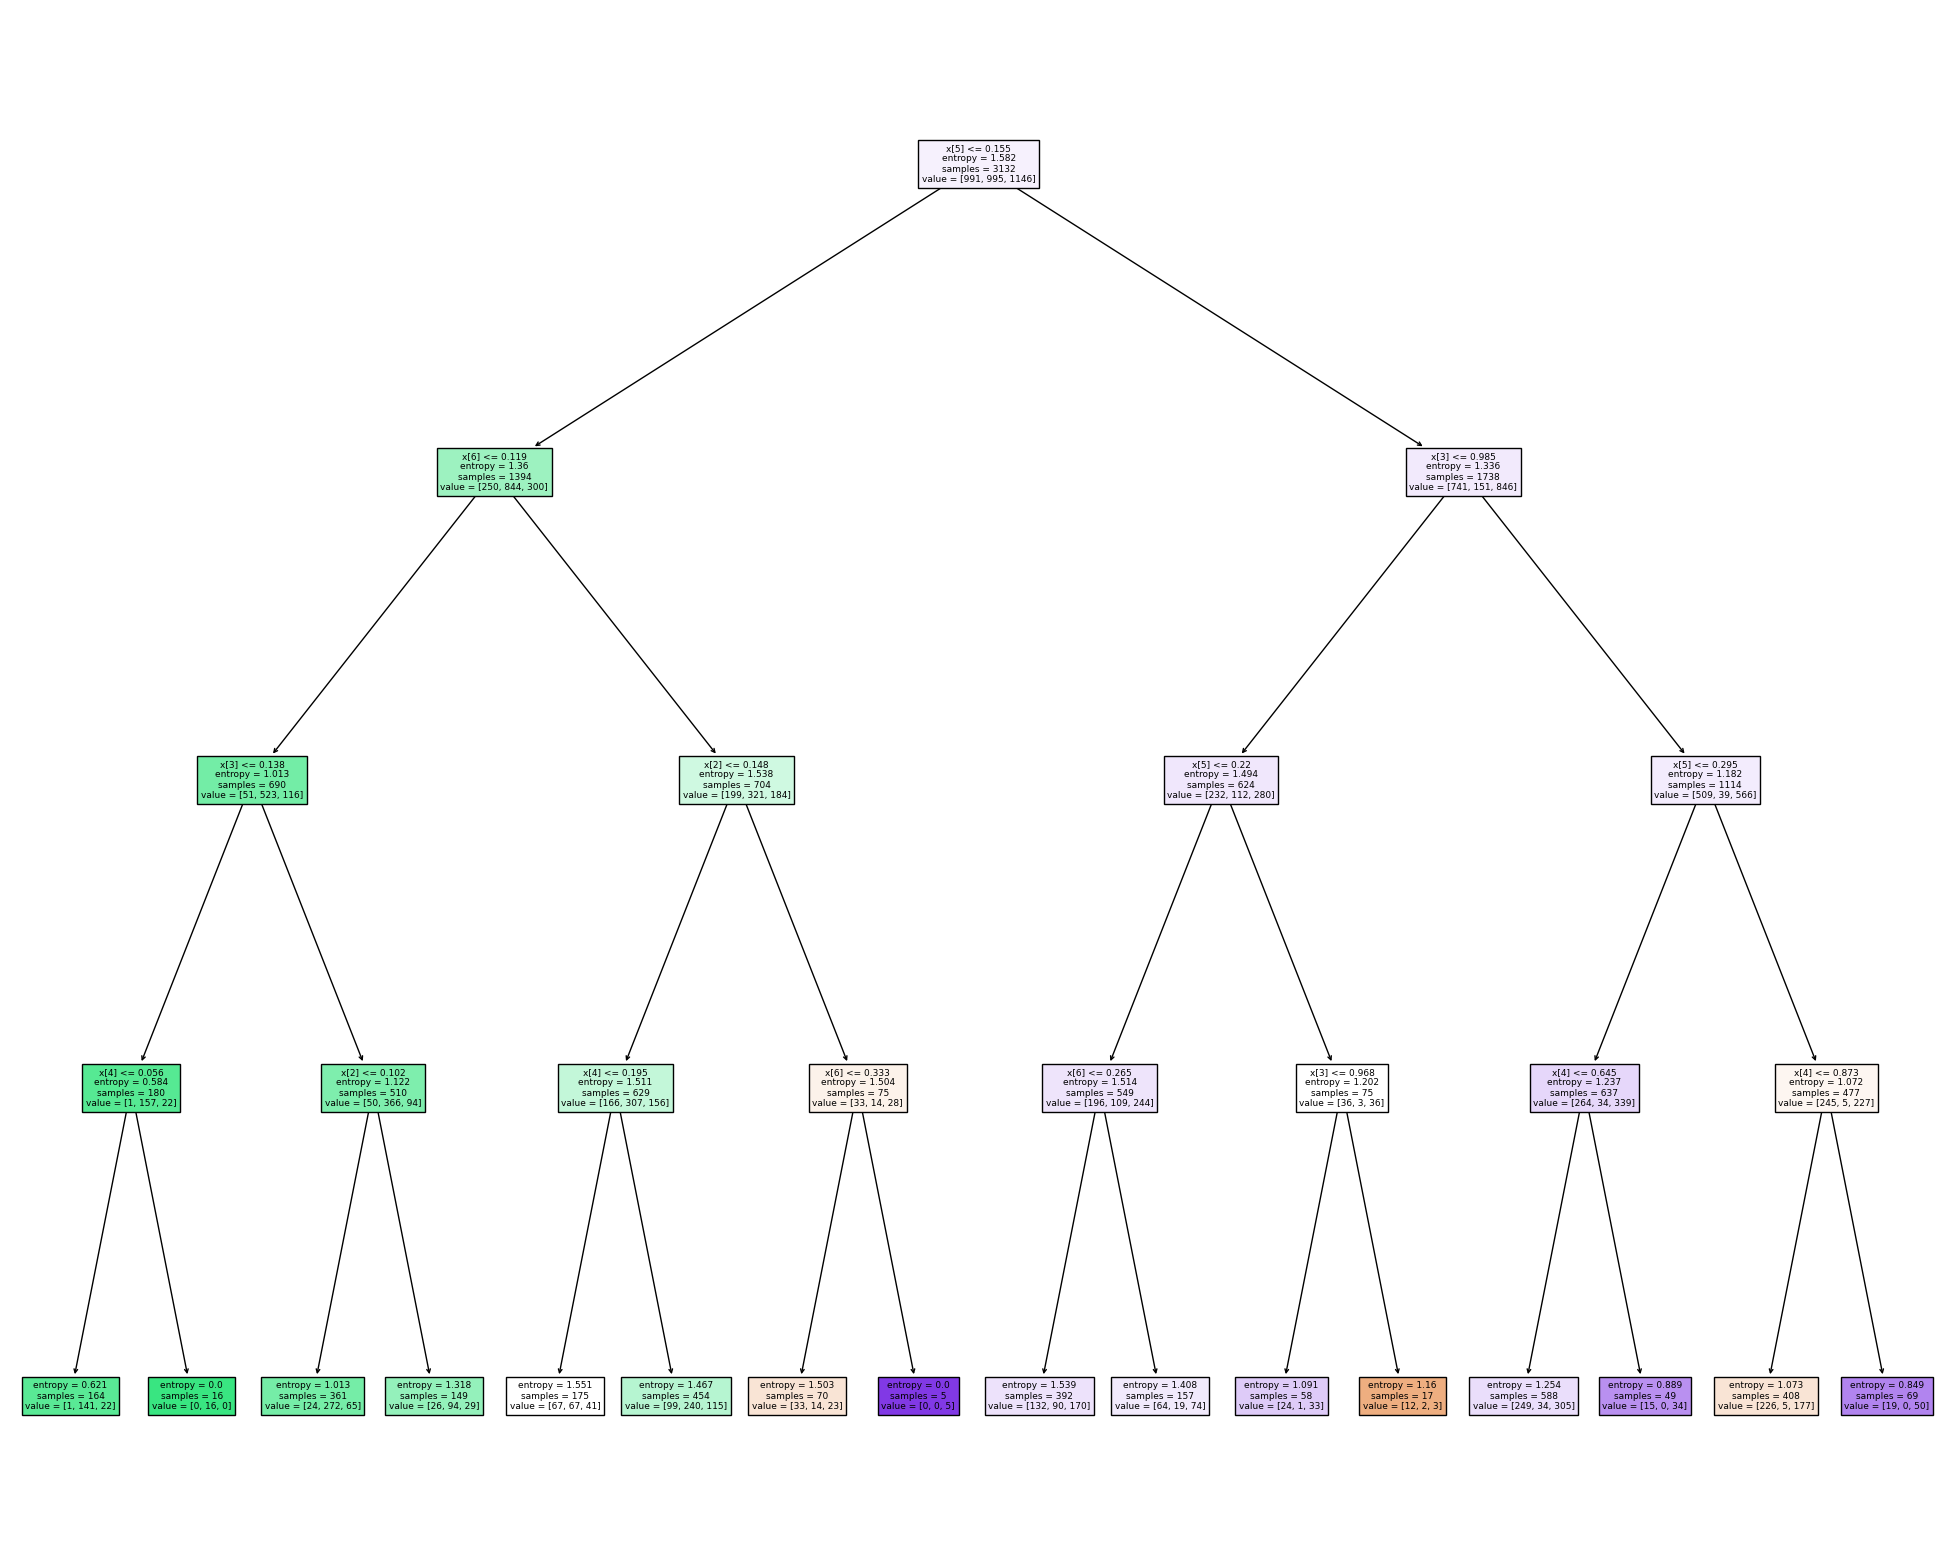

In [144]:
# Plot Top DT
top_dtc = tree.DecisionTreeClassifier()
top_dtc.set_params(**grid.best_params_)
top_dtc.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(top_dtc, filled=True)

In [145]:
# 5) Function to create confusion matrices
def plotConfusionMatrix(y_true, y_pred, classes, normalize = True, title = None, cmap = plt.cm.Blues,):
    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    #Ticks
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), 
           #labels
           xticklabels = classes, yticklabels = classes,
           title = title, ylabel = 'True label', xlabel = "Predicted label")
    
    #Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

    #Loop over data dimensions ad create text annotations
    fmt = '0.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = "center", va = "center",
                    color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)


In [146]:
#Open file to write to
fp = open('abalone-performance.txt', 'w')

              precision    recall  f1-score   support

           F       0.00      0.00      0.00       316
           I       0.65      0.80      0.72       347
           M       0.46      0.74      0.56       382

    accuracy                           0.54      1045
   macro avg       0.37      0.51      0.43      1045
weighted avg       0.38      0.54      0.45      1045



3

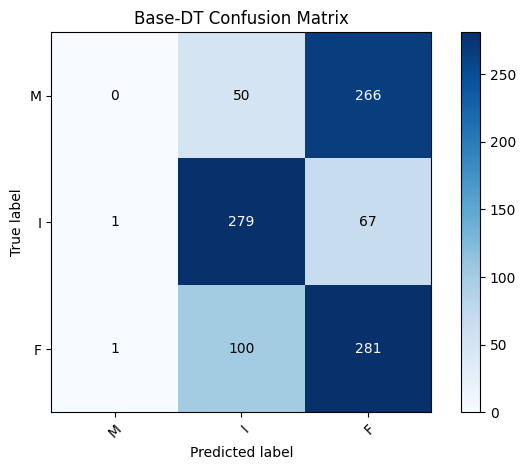

In [147]:
#Creating the confusion matrix for the Base-DT
fp.write('Base-DT with default parameters')
fp.write('\n \n')

y_predBaseDT = dtc.predict(X_test)
class_names = abalone.Type.value_counts().index
plotConfusionMatrix(y_test, y_predBaseDT, classes=class_names, normalize = False, title = "Base-DT Confusion Matrix")
fp.write("Confusion matrix: ")
fp.write('\n')
fp.write(str(confusion_matrix(y_test, y_predBaseDT)))
fp.write('\n \n')

# Creating the classification report for the Base-DT
print(classification_report(y_test, y_predBaseDT))
fp.write("Classification report:")
fp.write('\n \n')
fp.write(classification_report(y_test, y_predBaseDT))
fp.write('\n')

# 6) Repeating the Base-DT and finding all averages and variance
precisionScoresBDT = []
macroF1ScoresBDT = []
weightedF1ScoresBDT = []

for run in range(5):
    dtcBDT = tree.DecisionTreeClassifier()
    dtcBDT.fit(X_train, y_train)

    y_predBDT = dtcBDT.predict(X_test)

    precisionScoresBDT.append(dtcBDT.score(X_test, y_test))
    macroF1ScoresBDT.append(f1_score(y_test, y_predBDT, average='macro'))
    weightedF1ScoresBDT.append(f1_score(y_test, y_predBDT, average='weighted'))



# Writing all the information to the file
toWrite = "Average accuracy: " + str(np.mean(precisionScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the accuracy: " + str(np.var(precisionScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average macro-average F1: " + str(np.mean(macroF1ScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the macro-average F1: " + str(np.var(macroF1ScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average weighted-average F1: " + str(np.mean(weightedF1ScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the weighted-average F1: " + str(np.var(weightedF1ScoresBDT))
fp.write(toWrite)
fp.write('\n \n')



              precision    recall  f1-score   support

           F       0.46      0.34      0.39       316
           I       0.65      0.74      0.69       347
           M       0.46      0.51      0.48       382

    accuracy                           0.53      1045
   macro avg       0.52      0.53      0.52      1045
weighted avg       0.52      0.53      0.52      1045



3

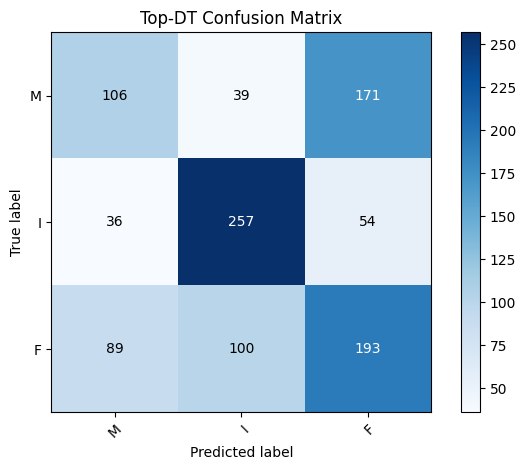

In [148]:
# Plotting confusion matrix for the Top-DT
fp.write('---------------------------------------------------------------------------------------------------------------')
fp.write('\n \n')
fp.write('Top-DT where the criterion, max_depth, and min_samples_split were changed')
fp.write('\n')
fp.write('Best hyperparameters found by gridsearch: ' + str(grid.best_params_))
fp.write('\n \n')

y_predTopDT = top_dtc.predict(X_test)
class_names = abalone.Type.value_counts().index
plotConfusionMatrix(y_test, y_predTopDT, classes=class_names, normalize = False, title = "Top-DT Confusion Matrix")
fp.write("Confusion matrix: ")
fp.write('\n')
fp.write(str(confusion_matrix(y_test, y_predTopDT)))
fp.write('\n \n')

# Creating the classification report for the Top-DT
print(classification_report(y_test, y_predTopDT))
fp.write("Classification report:")
fp.write('\n \n')
fp.write(classification_report(y_test, y_predTopDT))
fp.write('\n \n')




# 6) Repeating the Top-DT and finding all averages and variance
precisionScoresTDT = []
macroF1ScoresTDT = []
weightedF1ScoresTDT = []

for run in range(5):
    tree_para = {'criterion':['gini','entropy'],'max_depth':[4,8,None], 'min_samples_split':[2,3,5]}
    dtcTDT = tree.DecisionTreeClassifier()
    grid = GridSearchCV(dtcTDT, tree_para)
    grid.fit(X_train,y_train)

    dtcTDT.set_params(**grid.best_params_)
    dtcTDT.fit(X_train, y_train)

    y_predTDT = dtcTDT.predict(X_test)

    precisionScoresTDT.append(dtcTDT.score(X_test, y_test))
    macroF1ScoresTDT.append(f1_score(y_test, y_predTDT, average='macro'))
    weightedF1ScoresTDT.append(f1_score(y_test, y_predTDT, average='weighted'))



# Writing all the information to the file
toWrite = "Average accuracy: " + str(np.mean(precisionScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the accuracy: " + str(np.var(precisionScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average macro-average F1: " + str(np.mean(macroF1ScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the macro-average F1: " + str(np.var(macroF1ScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average weighted-average F1: " + str(np.mean(weightedF1ScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the weighted-average F1: " + str(np.var(weightedF1ScoresTDT))
fp.write(toWrite)
fp.write('\n \n')


In [149]:
# Closing the text file
fp.close()